
&nbsp;

# 04 - Diagnostiquer la stationnarité des anomalies

---

&nbsp;

> #### Les anomalies peuvent-elles être considérées comme stationnaires (ou quasi-stationnaire) pour l’analyse statistique et le SciML ?

Une hypothèse clé en statistique, notamment si on veut entraîner un modèle statistique linéaire ML, est la suppositon implicite que les données sont stationnaires (au moins faiblement). Il est donc indispensable de vérifier la véracité de l'hypothèse de stationnarité pour pouvoir discuter de la raisonnabilité des hypothèses du 
modèles (les prédictions).

Pourquoi ? Car l'entraînement du modèle sur un jeu de donnée non-stationnaire provoquerait une confusion entre tendance et dynamique au cours du processus de capture de la dynamique. 

Pour l'entraînement d'un modèle SciML, on ne va pas chercher à forcer la stationnarité mais plutôt à la contrôler. Cette classe de modèle peut gérer des forçages déterministes, des paramètres dépendants du temps ou des composantes saisonnières explicites. La série peut donc être non-stationnaire mais de manière maîtrisée.

À l'inverse, entraîner son modèle sur un jeu de donnée présumé stationnaire (ou quasi-stationnaire) permet notamment de s’assurer de la stabilité des moments statistiques du signal et de limiter l’apprentissage de structures non physiques liées à des dérives temporelles.

> Les anomalies considérées ici sont celles définies et validées dans le notebook 03.

Vérifions désormais que les propriétés statistiques des anomalies ne dérivent pas fortement dans le temps et qu'elles sont suffisament stables pour la modélisation et l'analyse.

&nbsp;

---

&nbsp;

## 1. Stabilité de la moyenne dans le temps

### 1.1 Observation de l'état de la stationnarité

Le premier critère pour étudier la stationnarité est d'observer la constance de la moyenne des anomalies dans le temps sur la période du jeu de donnée étudiée. Observons comment la propriété statistique du jeu de donnée préparée évolue.

Text(0, 0.5, '$\\mu$, Mean SST Anomaly (°C)')

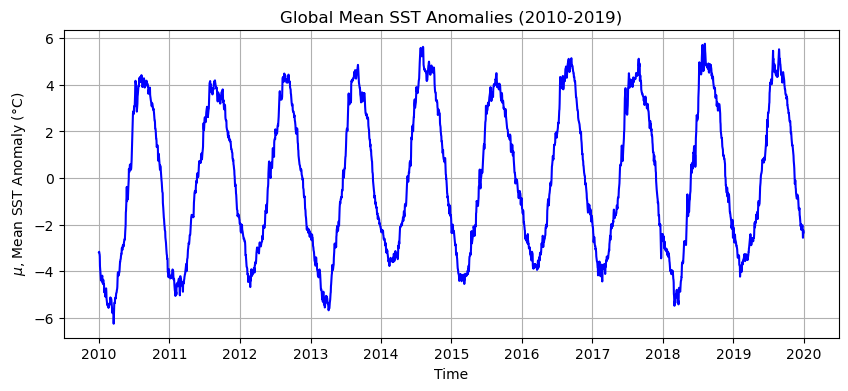

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the processed SST dataset

ds = xr.open_dataset("data/processed/sstCOPERNICUS20102019Processed.nc", chunks={"time":365}, decode_times=True)

# We compute again the SST anomalies for the English Channel region

sst = ds['analysed_sst']

sstMean = sst.mean(dim='time')

# Forcing the global mean of the time series to be zero

sstAnom = sst - sstMean

# Global mean SST anomaly time series plot

plt.figure(figsize=(10,4))
sstAnom.mean(dim=['latitude', 'longitude']).plot(color='blue')
plt.grid(True)
plt.title('Global Mean SST Anomalies (2010-2019)')
plt.ylabel('$\\mu$, Mean SST Anomaly (°C)')

On constate que la moyenne est indiscutablement inconstante dans le temps. L'amplitude des oscillations est relativement importante (entre -6° et 6°). On voit se dessiner une structure périodique déterministe. Il semble y avoir un pattern saisonnier dominant avec des cycles annuels très marqués de forme sinusoïdale (suite de pics et creux). On ne remarque pas de dérive générale.

Nous avons forcé la moyenne globale en "retirant" un offset constant (la moyenne temporelle sur 2010-2019) ce qui permet aux anomalies d'être gloablement centrées, mais pas les moyennes saisonnières, ce qui laisse un facteur saisonnalité fort. En l'état, la série est non-stationnaire.

&nbsp;

---

&nbsp;

### 1.2 Désaisonnalisation de la série temporelle

> #### Mais alors quel est le problème ?

Le problème n'est pas la moyenne, c'est la structure périodique déterministe. On peut décomposer notre série de la manière suivante :

$$
\mathrm{SST}(t) = S(t) + R(t)
$$

où :

- **$ \mathrm{SST}(t) $** : température de surface de la mer au temps \(t\)  
- **$ \mathrm{S}(t) $** : composante saisonnière déterministe (cycle climatologique annuel)  
- **$ \mathrm{R}(t) $** : résidu stochastique correspondant aux anomalies de SST désaisonnalisées

Dans notre cas, on souhaite entraîner notre modèle sur $ \mathrm{R}(t) $, le résidu stationnaire, mais pas sur $ \mathrm{S}(t) $. 

On va donc chercher à atténuer la composante saisonnière par soustraction d’une moyenne glissante sur 30 jours. On choisit 30 jours comme échelle physique naturelle raisonnable car elle est suffisamment longue pour lisser la variabilité journalière et suffisament courte pour pour ne pas écraser la variabilité interannuelle.

Text(0, 0.5, '$\\mu$, Mean Deseasonalized SST Anomaly (°C)')

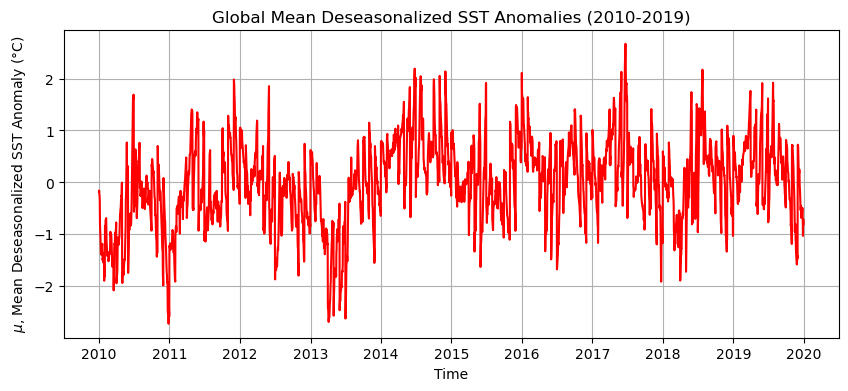

In [2]:
# Monthly climatology
sstClim = sst.groupby("time.month").mean("time")

# Deseasonalized SST
sstDs = sst.groupby("time.month") - sstClim

# See now how the deseasonalized SST anomalies look like

plt.figure(figsize=(10,4))
sstDs.mean(dim=['latitude', 'longitude']).plot(color='red')
plt.grid(True)
plt.title('Global Mean Deseasonalized SST Anomalies (2010-2019)')
plt.ylabel('$\\mu$, Mean Deseasonalized SST Anomaly (°C)')


Après désaisonnalisation, la série présente une stationnarité nettement améliorée. L'amplitude des oscillations est significativement réduite (entre -2.5° et 3°) et la série fluctue désormais autour d'une moyenne relativement stable. On remarque également que les cycles réguliers ont été éliminés.

La série, nouvellement désaisonnalisée, n'est pas parfaitement stationnaire puisqu'on observe encore des fluctuations irrégulières et une possible variabilité basse fréquence résiduelle qui tend à la hausse (sur 10 ans des fluctuations annuelles peuvent ressembler à une tendance). 

Text(0, 0.5, '$\\mu$, rolling meaned SST Anomaly (°C)')

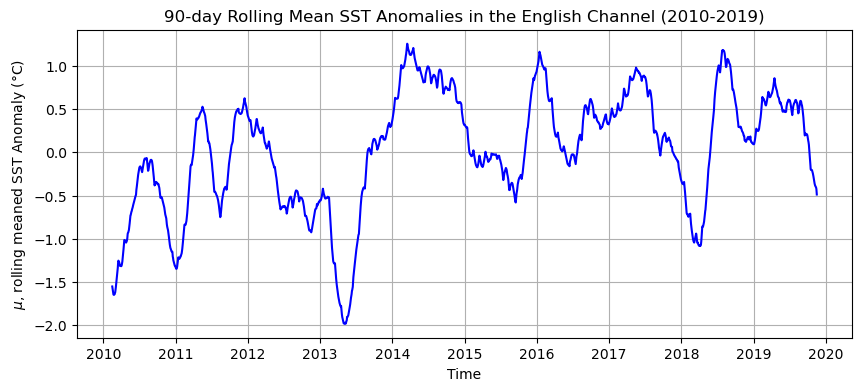

In [3]:
# Then we compute the 90-day rolling deseasonalized SST anomalies thanks to the rolling function

rollingMeanAnom = sstDs.rolling(time=90, center=True).mean()

plt.figure(figsize=(10,4))

# As we see, we are fixing longitude and latitude to a point in the English Channel and we look at the time series
rollingMeanAnom.sel(latitude=50.5, longitude=-1.0, method='nearest').plot(color='blue')

plt.grid(True)
plt.title('90-day Rolling Mean SST Anomalies in the English Channel (2010-2019)')
plt.ylabel('$\\mu$, rolling meaned SST Anomaly (°C)')

Text(0, 0.5, '$\\mu$, rolling meaned SST Anomaly (°C)')

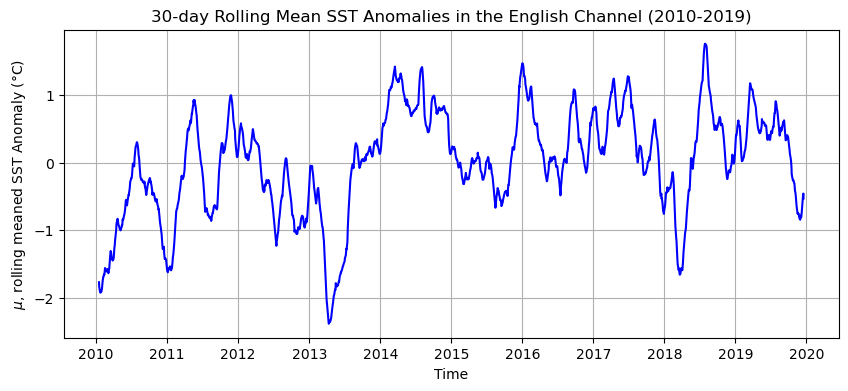

In [4]:
# Now, let's do the same but with a 30-day rolling mean

rollingMeanAnom = sstDs.rolling(time=30, center=True).mean()

plt.figure(figsize=(10,4))

rollingMeanAnom.sel(latitude=50.5, longitude=-1.0, method='nearest').plot(color='blue')

plt.grid(True)
plt.title('30-day Rolling Mean SST Anomalies in the English Channel (2010-2019)')
plt.ylabel('$\\mu$, rolling meaned SST Anomaly (°C)')


&nbsp;

---

&nbsp;

## 2. Stabilité de la variance dans le temps

Le second critère pour valider la stationnarité est d'évaluer la constance de σ, l'écart-type, dans le temps. Ce qu'on attend c'est une amplitude globalement stable, sans augmentation diminution progressive marquée. 

Comparons tout d'abord l'écart-type global en fonction sur du temps sur le jeu de donnée préparé de base puis désaisonnalisé.

Text(0, 0.5, '$\\sigma$, Standard Deviation (°C)')

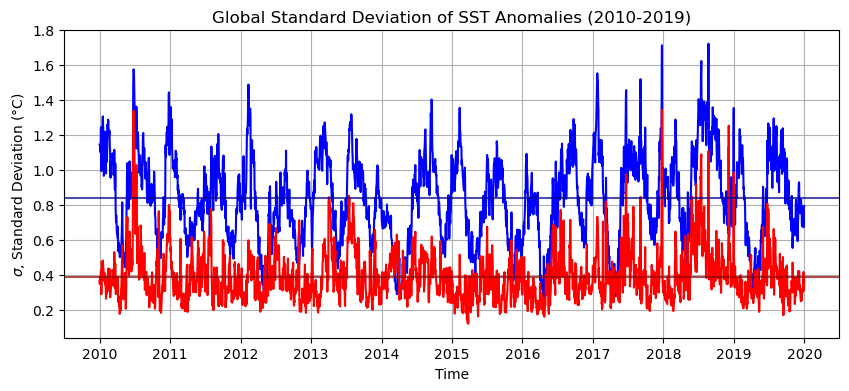

In [5]:
# Global standard deviation of the SST anomalies time series plot and of the deseasonalized SST anomalies time series plot

plt.figure(figsize=(10,4))

sstAnom.std(dim=['latitude', 'longitude']).plot(color='blue', label='SST Anomalies')
sstDs.std(dim=['latitude', 'longitude']).plot(color='red', label='Deseasonalized SST Anomalies')

# Compute mean standard deviations for annotations
meanAnom = float(sstAnom.std(dim=['latitude', 'longitude']).mean())
meanDs = float(sstDs.std(dim=['latitude', 'longitude']).mean())

# Add horizontal lines for mean standard deviations
plt.axhline(y=meanAnom, color='darkblue', linewidth=1.5, alpha=0.7, label=f'Mean σ (Anom): {meanAnom:.3f}°C')
plt.axhline(y=meanDs, color='darkred', linewidth=1.5, alpha=0.7, label=f'Mean σ (Deseas): {meanDs:.3f}°C')

plt.grid(True)
plt.title('Global Standard Deviation of SST Anomalies (2010-2019)')
plt.ylabel('$\\sigma$, Standard Deviation (°C)')

Comme nous l'avions constaté dans la partie 1, l'amplitude des fluctuations s'est vu réduite au moment de la désaisonnalisation. 

Par interprétation graphique, on remarque que l'écart-type tend à se stabiliser autour des 0.85 pour les données préparées de base et environ 0.4 pour les données désaisonnalisées. On observe toujours des pics importants ponctuellement mais on présumera le critère de constance de σ mieux respecté.

Observons également la variance glissante sur une fenêtre de 90 jours sur les 2 jeux de données.

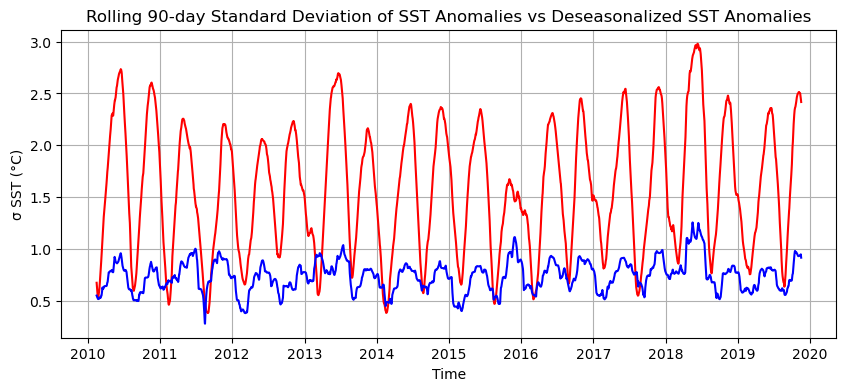

In [6]:
# Let's compare the rolling standard deviation of the SST anomalies and the deseasonalized SST on a 90-day window

rollingStd = sstAnom.rolling(time=90, center=True).std()
rollingDeseasonalStd = sstDs.rolling(time=90, center=True).std()

plt.figure(figsize=(10,4))

rollingStd.sel(latitude=50.5, longitude=-1.0, method='nearest').plot(color='red')
rollingDeseasonalStd.sel(latitude=50.5, longitude=-1.0, method='nearest').plot(color='blue')

plt.title("Rolling 90-day Standard Deviation of SST Anomalies vs Deseasonalized SST Anomalies")
plt.ylabel("σ SST (°C)")
plt.grid(True)


Ici, pas plus d'observations, on constate toujours la réduction de l'amplitude des fluctutations post-désaisonnalisation et une meilleur constance de l'écart-type dans le temps.

&nbsp;

> ### Que signifie ce changement post-detrending ?

La baisse de σ signifie que :

- une grande partie de la variabilité était déterministe et périodique

- le résidu correspond à : des anomalies régionales, des événements extrêmes ou des variabilités climatiques naturelles

&nbsp;

> ### Pourquoi ne pas chercher une stationnarité parfaite ?

La variabilité résiduelle est physiquement réelle, chercher la stationnarité en maximisant le lissage de σ reviendrait à enlever l'information que l'on souhaite faire apprendre au modèle.

Des tests formels de stationnarité (ADF, KPSS) ont été considérés. Toutefois, compte tenu de la nature non linéaire du signal et de l’objectif de modélisation SciML, l’analyse repose principalement sur des diagnostics visuels et physiques.

&nbsp;

---

&nbsp;

## 3. Comparaison de la distribution des anomalies avant et après detrending

Text(0.5, 0, 'Anomalie SST (°C)')

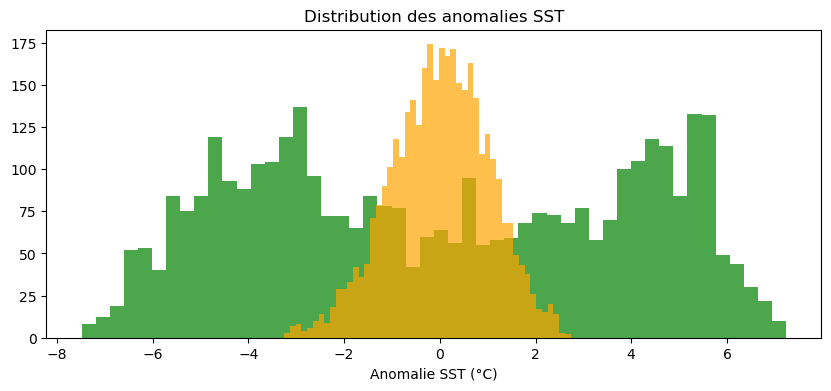

In [7]:
plt.figure(figsize=(10,4))

sstAnom.sel(latitude=50.5, longitude=-1.0, method='nearest').plot.hist(bins=50, color='green', alpha=0.7)
sstDs.sel(latitude=50.5, longitude=-1.0, method='nearest').plot.hist(bins=50, color='orange', alpha=0.7)

plt.title("Distribution des anomalies SST")
plt.xlabel("Anomalie SST (°C)")


Avant detrending, la distribution est de forme non-gaussienne, très étalée (-8° à 6°), multimodale (aplatie) et particulièrement asymétrique. Dans ce cas, la saisonnalité domine totalement le signal, biaisant la distribution en raison de la composante déterministe.

Après detrending, la distribution est de forme quasi-gaussienne, avec une dispersion fortement réduite (-3° à 3°), recentrée fortement autour de 0 et devient raisonnablement symétrique. C'est exactement ce que l'on va attendre, le résidu est dominé par des fluctuations aléatoires.

Cela ne confirme en rien la stationnarité temporelle mais cela confirme la cohérence statistique du signal que l'on traite désormais. La désaisonnalisation n'a pas détruit la structure statistique, le signal est désormais statistiquement homogène, prêt à être analyser.

&nbsp;

---

&nbsp;

## 4. Sauvegarde du signal désaisonnalisé

In [8]:
# Save deaseasonalized SST anomalies to a new NetCDF file

sstDs.to_netcdf("data/processed/sstDeseasonalizedCOPERNICUS20102019.nc")